In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
articles_df = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/DataScopus/AnalisisGrafos/raw_data/articles.csv")
authors_df = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/DataScopus/AnalisisGrafos/raw_data/authors.csv")
author_article_links_df = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/DataScopus/AnalisisGrafos/raw_data/articles_authors.csv")
affiliations_df = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/DataScopus/AnalisisGrafos/raw_data/affiliations.csv")
author_institution_links_df = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/DataScopus/AnalisisGrafos/raw_data/authors_affiliations.csv")

In [3]:
author_links = author_article_links_df.merge(
    author_institution_links_df, on='author_id', how='left'
)

# 2. Merge with institution data
author_links = author_links.merge(
    affiliations_df, left_on='affiliation_id', right_on='identifier', how='left', suffixes=('', '_inst')
)

# 3. Merge with article data to bring in publication details
full_df = author_links.merge(
    articles_df, left_on='article_id', right_on='identifier', how='left', suffixes=('', '_article')
)

# 4. Extract year for grouping
full_df['pub_year'] = pd.to_datetime(full_df['publication_date']).dt.year

# 4. Extract year for grouping
full_df['pub_year'] = pd.to_datetime(full_df['publication_date'], errors='coerce').dt.year

# Filter
full_df = full_df[
    (full_df['pub_year'] >= 1990) &
    (full_df['pub_year'] <= 2019)
]

# 5. Group by institution and year
inst_yearly_counts = (
    full_df.groupby(['affiliation_name', 'pub_year'])
    .agg(num_publications=('article_id', 'nunique'))
    .reset_index()
)

# Only keep institutions with at least 2 years of data
filtered_inst_yearly_counts = (
    inst_yearly_counts.groupby("affiliation_name")
    .filter(lambda x: x['pub_year'].nunique() >= 2)
)

In [4]:
target_institution = 'Universidad Central del Ecuador'

📊 Evaluation for Universidad Central del Ecuador
Model Used: Linear Regression
Actual 2019: 342
Predicted 2019: 144.43
MAE: 197.57 | RMSE: 39035.44

🔮 Forecast 2025–2035 using Linear Regression:
2022: 162.75
2023: 168.86
2024: 174.97
2025: 181.08
2026: 187.19
2027: 193.3
2028: 199.41
2029: 205.51
2030: 211.62
2031: 217.73
2032: 223.84
2033: 229.95
2034: 236.06
2035: 242.17


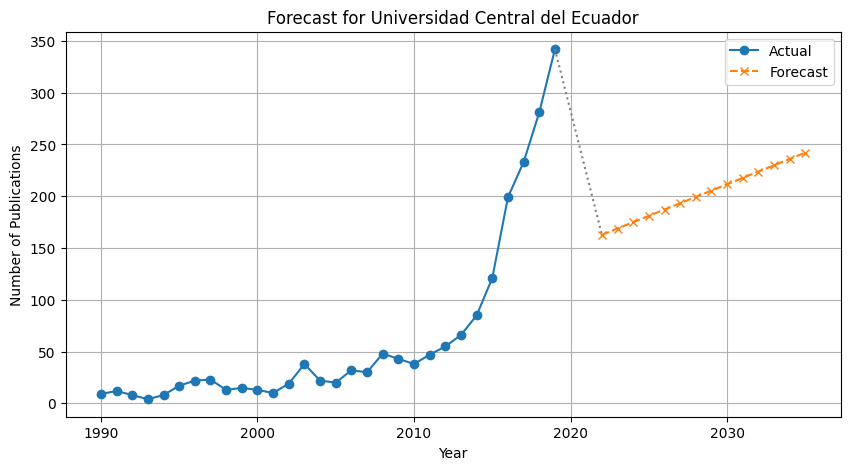

In [8]:
group = inst_yearly_counts[inst_yearly_counts['affiliation_name'] == target_institution].sort_values("pub_year")

# Check the number of years
num_years = group['pub_year'].nunique()
if num_years < 2:
    print("❌ Not enough data to evaluate.")
else:
    # ---------- EVALUATE using data before 2019 ---------- #
    train_eval = group[group['pub_year'] < 2019]
    actual_2019 = group[group['pub_year'] == 2019]['num_publications'].values

    if len(actual_2019) == 0 or len(train_eval) < 2:
        print("⚠️ Cannot evaluate: no actual 2019 data or too little history.")
    else:
        X_eval = train_eval['pub_year'].values.reshape(-1, 1)
        y_eval = train_eval['num_publications'].values

        if len(X_eval) >= 5:
            model = LinearRegression().fit(X_eval, y_eval)
            pred_2019 = model.predict(np.array([[2019]]))[0]
            model_type = 'Linear Regression'
        elif 3 <= len(X_eval) < 5:
            poly = PolynomialFeatures(degree=2)
            model = LinearRegression().fit(poly.fit_transform(X_eval), y_eval)
            pred_2019 = model.predict(poly.transform(np.array([[2019]])))[0]
            model_type = 'Polynomial Regression'
        else:
            pred_2019 = np.mean(y_eval)
            model_type = 'Mean Predictor'

        mae = mean_absolute_error(actual_2019, [pred_2019])
        rmse = mean_squared_error(actual_2019, [pred_2019])

        print(f"📊 Evaluation for {target_institution}")
        print(f"Model Used: {model_type}")
        print(f"Actual 2019: {actual_2019[0]}")
        print(f"Predicted 2019: {round(pred_2019, 2)}")
        print(f"MAE: {round(mae, 2)} | RMSE: {round(rmse, 2)}")

    # ---------- FORECAST 2025–2035 ---------- #
    train_full = group[group['pub_year'] < 2019]
    X_full = train_full['pub_year'].values.reshape(-1, 1)
    y_full = train_full['num_publications'].values

    future_years = np.arange(2022, 2036).reshape(-1, 1)

    if len(X_full) >= 5:
        model = LinearRegression().fit(X_full, y_full)
        preds = model.predict(future_years)
        forecast_model = 'Linear Regression'
    elif 3 <= len(X_full) < 5:
        poly = PolynomialFeatures(degree=2)
        model = LinearRegression().fit(poly.fit_transform(X_full), y_full)
        preds = model.predict(poly.transform(future_years))
        forecast_model = 'Polynomial Regression'
    else:
        preds = [np.mean(y_full)] * len(future_years)
        forecast_model = 'Mean Predictor'

    print(f"\n🔮 Forecast 2025–2035 using {forecast_model}:")
    for year, pred in zip(future_years.flatten(), preds):
        print(f"{year}: {round(pred, 2)}")

    # ---------- Plot Actual + Forecast ---------- #
    plt.figure(figsize=(10, 5))
    plt.plot(group['pub_year'], group['num_publications'], marker='o', label='Actual')
    # Dotted line connecting last actual to first predicted
    plt.plot(
        [group['pub_year'].max(), future_years[0][0]],
        [group['num_publications'].iloc[-1], preds[0]],
        linestyle='dotted', color='gray'
    )
    plt.plot(future_years.flatten(), preds, linestyle='--', marker='x', label='Forecast')
    plt.title(f"Forecast for {target_institution}")
    plt.xlabel("Year")
    plt.ylabel("Number of Publications")
    plt.grid(True)
    plt.legend()
    plt.show()